In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import fu
from FRVRS import nu
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape) # (842663, 112)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829277, 113)



# Convert Tag Applied Type to Patient Record SALT

In [4]:

# Initialize (if necessary) an empty data frame to store injury severity data and iterate over the patient groups
if nu.pickle_exists('tag_to_salt_df'): tag_to_salt_df = nu.load_object('tag_to_salt_df')
else:
    
    # Iterate through each patient of each run of each session
    gb = frvrs_logs_df.sort_values(['action_tick']).groupby(fu.patient_groupby_columns)
    rows_list = []
    for (session_uuid, scene_id, patient_id), patient_df in gb:
        
        # Add the logger version, groupby columns, and other run characteristics to the row dictionary
        row_dict = {}
        for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
        row_dict['logger_version'] = fu.get_logger_version(patient_df)
        row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(patient_df)
        row_dict['scene_type'] = fu.get_scene_type(patient_df)
        row_dict['is_a_one_triage_file'] = fu.get_is_a_one_triage_file(patient_df)
        row_dict['patient_count'] = 1

        # Get non-null tag applied types and patient record SALTs
        mask_series = ~patient_df.tag_applied_type.isnull() | ~patient_df.patient_record_salt.isnull()
        tags_and_salts_df = patient_df[mask_series]

        # Add the last tag value
        last_tag = fu.get_last_tag(tags_and_salts_df)
        row_dict['last_tag'] = last_tag

        # Add the max salt value
        max_salt = fu.get_max_salt(patient_df=tags_and_salts_df)
        row_dict['max_salt'] = max_salt
        
        # Add the predicted tag value
        try: predicted_tag = fu.salt_to_tag_dict.get(max_salt, np.nan)
        except Exception: predicted_tag = np.nan
        row_dict['predicted_tag'] = predicted_tag
        
        # Add if tag is correct
        row_dict['is_tag_correct'] = bool(last_tag == predicted_tag)

        # Add the row dictionary to the list
        rows_list.append(row_dict)
    
    # Store the patient history data frame
    tag_to_salt_df = pd.DataFrame(rows_list)
    nu.store_objects(tag_to_salt_df=tag_to_salt_df, verbose=True)


## Display some pie charts

In [14]:

print(tag_to_salt_df.columns.tolist())
display(tag_to_salt_df.sample(11).T)

['session_uuid', 'scene_id', 'patient_id', 'logger_version', 'is_scene_aborted', 'scene_type', 'is_a_one_triage_file', 'patient_count', 'last_tag', 'max_salt', 'predicted_tag', 'is_tag_correct']


,845,5216,3891,1790,2654,1653,3115,1134,1709,4606,1561
session_uuid,206da802-d38f-4f3a-98e3-44f99481479d,e8be80d7-4d11-430d-93b7-bc15e1bfb445,a98b7327-dfd7-43c2-86e7-b5080ec86806,48c426ae-e88c-49bd-8010-37dc7b042c95,724fdf45-3165-43b8-b9ca-dc07102d2886,4226ad6c-bb0a-4df0-8c4a-64c312927578,845d87c5-7b8b-4bf3-bfc6-91c74e285243,2d26ca7b-1dbb-42e4-9bbf-bf0d131e2e06,44458d4a-3cce-4907-85e3-3db1375ce6bb,d11543fd-7b7f-4883-bd69-afe8128a76f2,3f142e7e-1e18-4341-947a-71f2e7f35aa2
scene_id,1,0,1,0,3,1,1,0,0,0,0
patient_id,Lily_4 Root,Lily_4 Root,Bob_0 Root,Mike_4 Root,Helga_10 Root,Gary_9 Root,Bob_7 Root,Gloria_8 Root,Mike_5 Root,Gloria_6 Root,Mike_2 Root
logger_version,1.0,1.3,1.3,1.0,1.0,1.0,1.0,1.0,1.0,1.3,1.0
is_scene_aborted,False,False,False,False,False,False,False,False,False,False,False
scene_type,Triage,Triage,Triage,Triage,Triage,Triage,Triage,Triage,Triage,Triage,Orientation
is_a_one_triage_file,True,True,True,True,False,True,False,True,True,True,True
patient_count,1,1,1,1,1,1,1,1,1,1,1
last_tag,yellow,yellow,black,yellow,NaN,red,NaN,NaN,red,red,yellow
max_salt,IMMEDIATE,IMMEDIATE,DEAD,MINIMAL,MINIMAL,MINIMAL,DELAYED,DELAYED,IMMEDIATE,DELAYED,IMMEDIATE


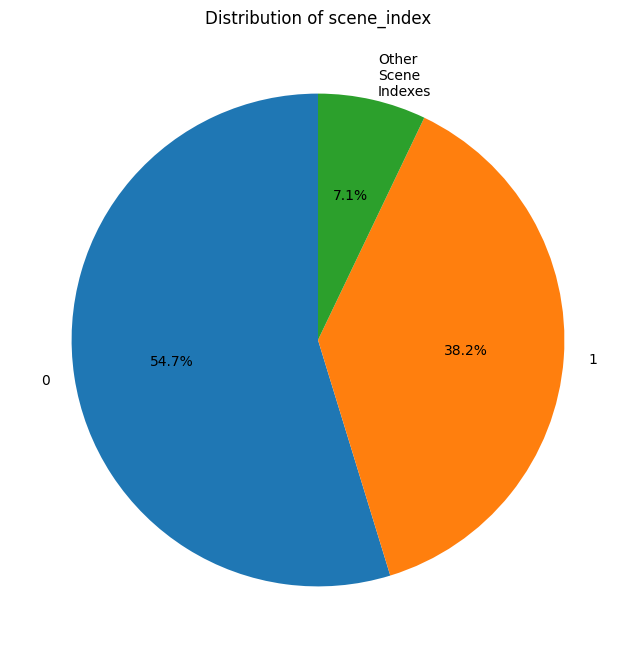

In [58]:

nu.plot_grouped_pie_chart('scene_id', 'Other\nScene\nIndexes', slice_cutoff=128)

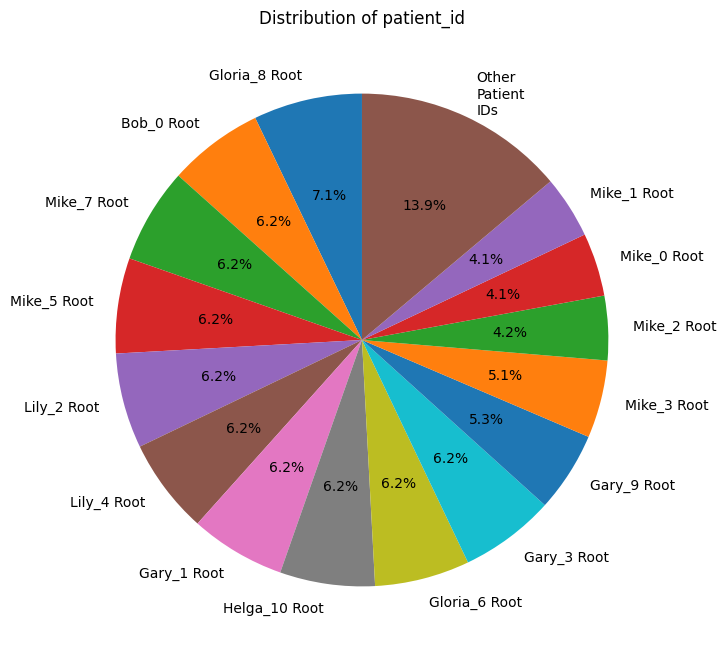

In [59]:

nu.plot_grouped_pie_chart('patient_id', 'Other\nPatient\nIDs', slice_cutoff=None)

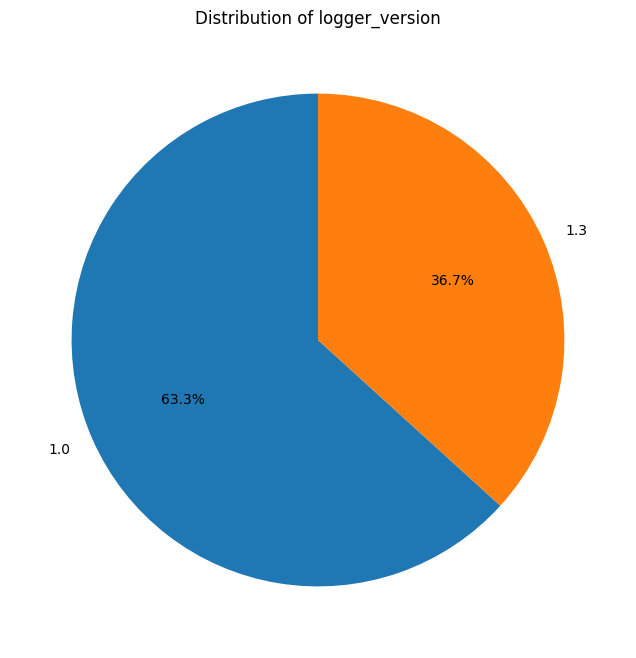

In [62]:

nu.plot_grouped_pie_chart('logger_version', 'Other\nLogger\nVersions', slice_cutoff=None, verbose=True)

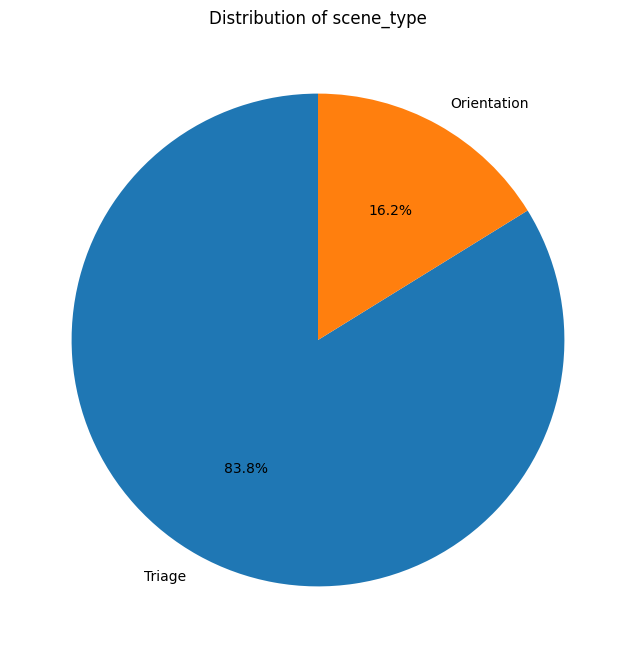

In [65]:

nu.plot_grouped_pie_chart('scene_type', 'Other\nScene\nTypes', slice_cutoff=None, verbose=True)

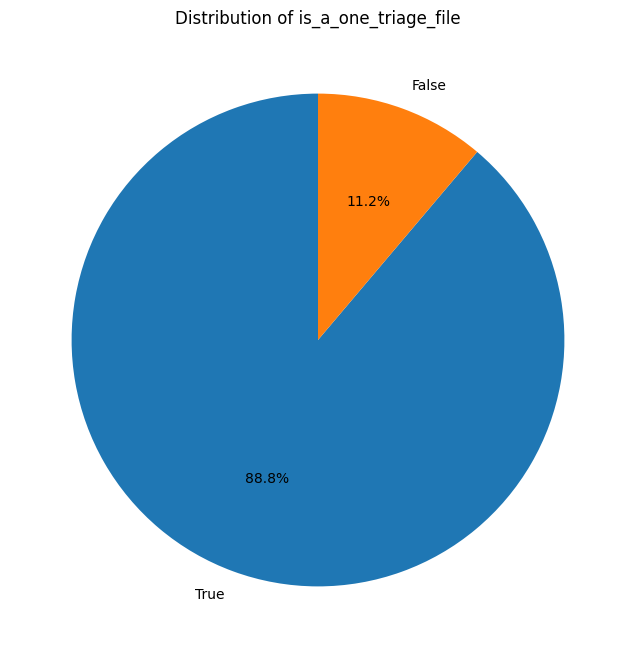

In [67]:

nu.plot_grouped_pie_chart('is_a_one_triage_file', 'Other\nFile\nCounts', slice_cutoff=None, verbose=True)

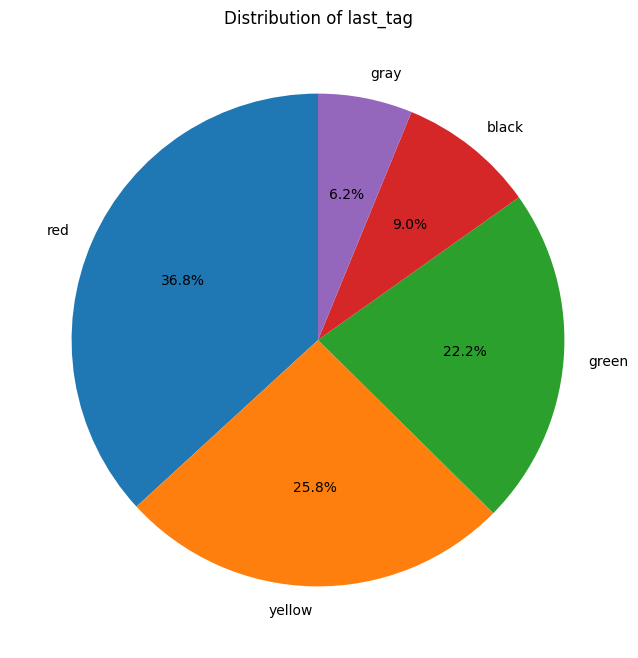

In [69]:

nu.plot_grouped_pie_chart('last_tag', 'Other\nLast\nTags', slice_cutoff=None, verbose=True)

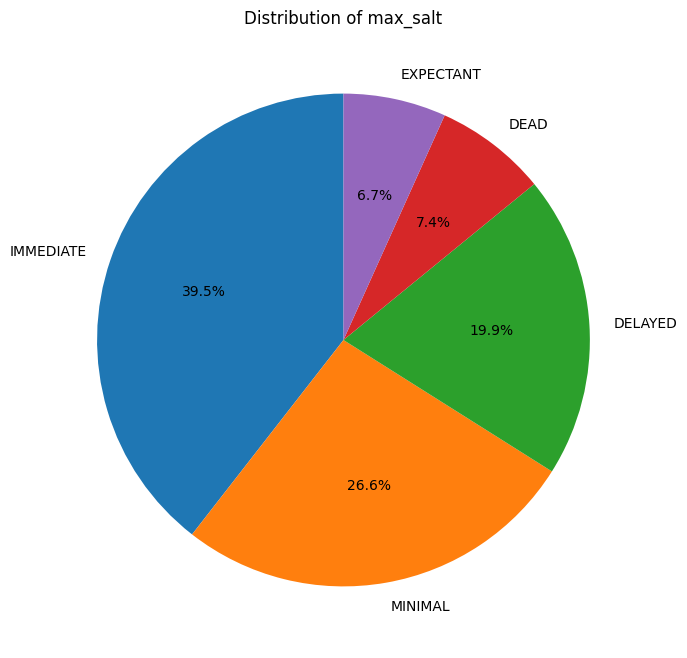

In [70]:

nu.plot_grouped_pie_chart('max_salt', 'Other\nMax\nSALTs', slice_cutoff=None, verbose=True)

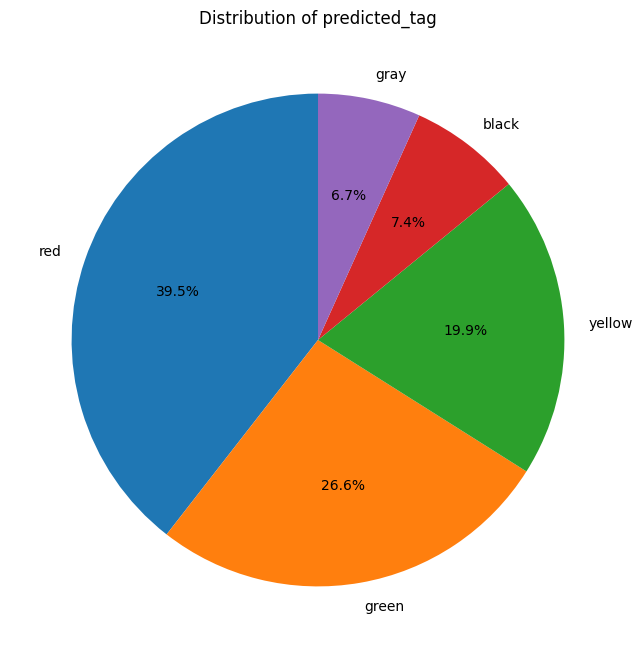

In [71]:

nu.plot_grouped_pie_chart('predicted_tag', 'Other\nPredicted\nTags', slice_cutoff=None, verbose=True)

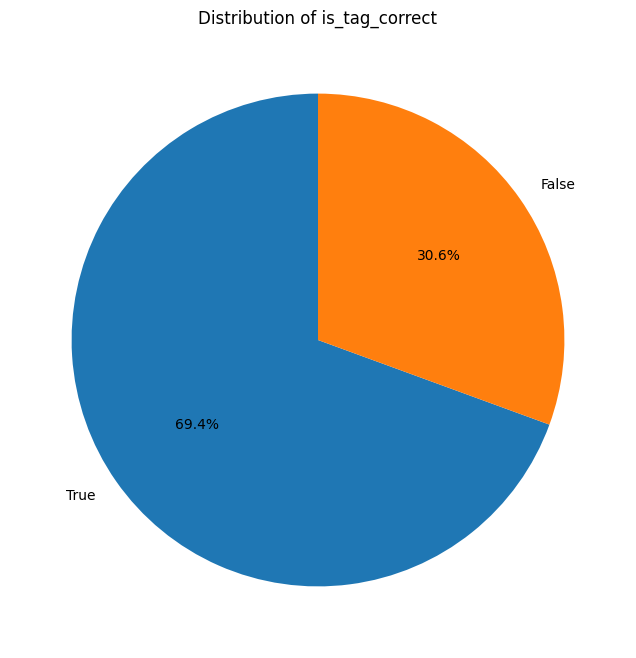

In [72]:

nu.plot_grouped_pie_chart('is_tag_correct', 'Other\nCorrect\nConclusions', slice_cutoff=None, verbose=True)